In [8]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Reproduce Table 7 of D. Baye, Phys. Rep. 565 (2015) 1
# -------------------------------------------------------------
import numpy as np
import pandas as pd
from numpy.polynomial.laguerre import lagroots, lagval

# --- utilidades de malla Laguerre (α = 0) --------------------
def laguerre_roots_weights(N: int):
    """Ceros x_j de L_N y pesos de Gauss λ_j (α = 0)."""
    x = np.real(lagroots([0] * N + [1]))                        # L_N(x) = 0
    L_Np1 = lagval(x, [0] * (N + 1) + [1])                      # L_{N+1}(x_j)
    lam = x / ((N + 1) ** 2 * L_Np1 ** 2)                       # λ_j (3.51)
    return x, lam

def kinetic_matrix(N: int, x: np.ndarray):
    """Matriz exacta T̂ (3.75–3.77) regularizada por x (α = 0)."""
    T_G = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                T_G[i, j] = (-1) ** (i - j) * (x[i] + x[j]) / (
                    np.sqrt(x[i] * x[j]) * (x[i] - x[j]) ** 2
                )
            else:
                T_G[i, i] = -(
                    x[i] ** 2 - 2 * (2 * N + 1) * x[i] - 4
                ) / (12 * x[i] ** 2)

    # Corrección exacta (3.77)
    diff = np.subtract.outer(np.arange(N), np.arange(N))
    corr = (-1.0) ** diff / (4 * np.sqrt(np.outer(x, x)))
    np.fill_diagonal(corr, 1 / (4 * x))                        # porque (-1)^0 = 1
    return T_G - corr

def hydrogen_hamiltonian(N: int, h: float):
    """Hamiltoniano de malla (5.20) para l = 0."""
    x, _ = laguerre_roots_weights(N)
    T = kinetic_matrix(N, x)
    H = (1 / (2 * h ** 2)) * T - np.diag(1 / (h * x))
    return x, H

# --- cálculo y observables -----------------------------------
def solve_hydrogen(N: int, h: float, n_max: int = 10):
    x, H = hydrogen_hamiltonian(N, h)
    evals, evecs = np.linalg.eigh(H)
    order = np.argsort(evals)[:n_max]                           # estados más ligados
    evals, evecs = evals[order], evecs[:, order]

    results = []
    for n, (E, c) in enumerate(zip(evals, evecs.T), start=1):
        r_exp = np.sum(c ** 2 * (h * x))                       # ⟨r⟩  (2.82)
        V_exp = np.sum(c ** 2 * (-1 / (h * x)))                # ⟨V⟩  (2.82)
        T_exp = c @ ((1 / (2 * h ** 2)) * kinetic_matrix(N, x) @ c)  # ⟨T⟩ (2.81)

        results.append(
            dict(
                n=n,
                E_Ha=E,
                two_n2_E=2 * n ** 2 * E,
                r_over_n2=r_exp / n ** 2,
                V_over_T=V_exp / T_exp,
                setup=f"N={N}, h={h}",
            )
        )
    return pd.DataFrame(results)

# --- tres configuraciones de la Tabla 7 ----------------------
def reproduce_table7():
    # 1) malla óptima por nivel (N = n, h = n/2)
    opt = [
        solve_hydrogen(n, n / 2.0, 1).iloc[0]                  # solo el nivel n
        for n in range(1, 8)
    ]
    df_opt = pd.DataFrame(opt).assign(setup="N=n, h=n/2")

    # 2) N = 30, h = 2
    df_h2 = solve_hydrogen(30, 2.0, 10)

    # 3) N = 30, h = 3
    df_h3 = solve_hydrogen(30, 3.0, 10)

    return pd.concat([df_opt, df_h2, df_h3], ignore_index=True)

if __name__ == "__main__":
    pd.set_option("display.float_format", "{: .12f}".format)
    tabla7 = reproduce_table7()
    print(tabla7.to_string(index=False))


 n            E_Ha        two_n2_E       r_over_n2        V_over_T       setup
 1 -1.000000000000 -2.000000000000  0.500000000000 -2.000000000000  N=n, h=n/2
 1 -0.779508497187 -1.559016994375  0.658359213500 -1.874563102581  N=n, h=n/2
 1 -0.730226875553 -1.460453751106  0.762645047990 -1.902356673885  N=n, h=n/2
 1 -0.707882741960 -1.415765483921  0.815948267933 -1.922164334912  N=n, h=n/2
 1 -0.695019109792 -1.390038219585  0.848101009129 -1.935610964567  N=n, h=n/2
 1 -0.686631959171 -1.373263918341  0.869603714055 -1.945181764665  N=n, h=n/2
 1 -0.680722702126 -1.361445404253  0.885000260530 -1.952306033906  N=n, h=n/2
 1 -0.500000000038 -1.000000000076  1.500000007607 -1.999999997712 N=30, h=2.0
 2 -0.125000000000 -1.000000000000  1.500000000000 -2.000000000000 N=30, h=2.0
 3 -0.055555555556 -1.000000000000  1.500000000000 -2.000000000000 N=30, h=2.0
 4 -0.031250000000 -1.000000000000  1.500000000000 -2.000000000000 N=30, h=2.0
 5 -0.020000000000 -1.000000000000  1.500000000000 -

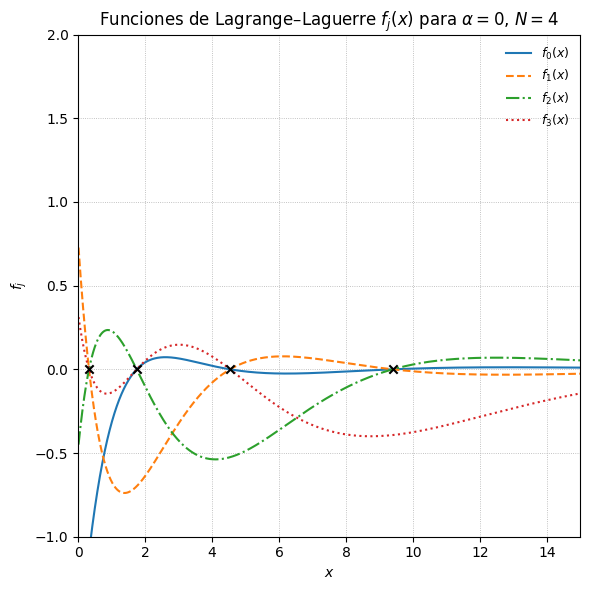

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_genlaguerre
from numpy.polynomial.laguerre import lagroots

# Parámetros
alpha = 0
N = 4

# Raíces del Laguerre L_N^{alpha}(x)
zeros = lagroots([0, 0, 0, 0, 1])
x_j = np.sort(zeros)

def fj(x, j):
    xj = x_j[j]
    return (-1)**j * np.sqrt(xj) * eval_genlaguerre(N, alpha, x) / (x - xj) * np.exp(-x/2)

# Malla de evaluación
x_vals = np.linspace(0.01, 15, 4000)

# Estilos
line_styles = ['-', '--', '-.', ':']

# Plot
fig, ax = plt.subplots(figsize=(6, 6))  # cuadrado para ejes parecidos
for j in range(N):
    ax.plot(x_vals, fj(x_vals, j), line_styles[j % len(line_styles)], lw=1.5, label=rf"$f_{j}(x)$")

# Puntos de malla
ax.scatter(x_j, np.zeros_like(x_j), color='black', marker='x', zorder=5)

# Rango de ejes
ax.set_xlim(0, 15)
ax.set_ylim(-1, 2)

# Aspecto: 1 unidad en y = 5 unidades en x  ⇒  aspecto = 5
ax.set_aspect(5)

# Etiquetas y título
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f_j$")
ax.set_title(r"Funciones de Lagrange–Laguerre $f_j(x)$ para $\alpha=0$, $N=4$")

# Cuadrícula ligera
ax.grid(True, ls=":", lw=0.6)

# Leyenda compacta
ax.legend(frameon=False, fontsize=9)

plt.tight_layout()
